### Import Library

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Splitting Data

In [3]:
base_dir = r'D:\kuliah\Tel-U\penting\tugas\semester 8\Tugas Akhir\CodeModel'
normal_dir = os.path.join(base_dir, 'normal')
pneumonia_dir = os.path.join(base_dir, 'pneumonia')

normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir)]

normal_labels = [0] * len(normal_images)
pneumonia_labels = [1] * len(pneumonia_images)

all_images = normal_images + pneumonia_images
all_labels = normal_labels + pneumonia_labels

X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


### Preprocessing Data

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Flow from directory untuk training
train_generator = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Flow from directory untuk validation
val_generator = train_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Flow from directory untuk testing
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 541 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Found 675 images belonging to 2 classes.


In [5]:
print("Training Generator:", train_generator.samples)
print("Validation Generator:", val_generator.samples)
print("Test Generator:", test_generator.samples)

Training Generator: 541
Validation Generator: 134
Test Generator: 675


### DenseNet169 Model

In [6]:
def create_densenet169_model():
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

densenet169_model = create_densenet169_model()

### Train Model

In [7]:
history = densenet169_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

Epoch 1/50
17/17 [==============================] - 94s 4s/step - loss: 0.4653 - accuracy: 0.7782 - val_loss: 0.2149 - val_accuracy: 0.9478
Epoch 2/50
17/17 [==============================] - 46s 3s/step - loss: 0.1458 - accuracy: 0.9667 - val_loss: 0.1444 - val_accuracy: 0.9627
Epoch 3/50
17/17 [==============================] - 45s 3s/step - loss: 0.0969 - accuracy: 0.9704 - val_loss: 0.1096 - val_accuracy: 0.9552
Epoch 4/50
17/17 [==============================] - 46s 3s/step - loss: 0.0602 - accuracy: 0.9834 - val_loss: 0.1177 - val_accuracy: 0.9552
Epoch 5/50
17/17 [==============================] - 45s 3s/step - loss: 0.0463 - accuracy: 0.9871 - val_loss: 0.1229 - val_accuracy: 0.9627
Epoch 6/50
17/17 [==============================] - 47s 3s/step - loss: 0.0395 - accuracy: 0.9926 - val_loss: 0.0955 - val_accuracy: 0.9701
Epoch 7/50
17/17 [==============================] - 44s 3s/step - loss: 0.0494 - accuracy: 0.9815 - val_loss: 0.0831 - val_accuracy: 0.9552
Epoch 8/50
17/17 [==

### evaluate model

In [8]:
def evaluate_model(model, test_generator):
    y_pred = model.predict(test_generator)
    y_pred = np.round(y_pred).astype(int)
    y_true = test_generator.classes

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-Score: {f1}')

    return accuracy, precision, recall, f1

print("Evaluating densenet169")
accuracy, precision, recall, f1 = evaluate_model(densenet169_model, test_generator)

Evaluating densenet169
22/22 [==============================] - 19s 703ms/step
Accuracy: 0.9940740740740741
Precision: 1.0
Recall: 0.9909297052154195
F1-Score: 0.9954441913439636


In [9]:
import pandas as pd

results = {
    'Model': ['InceptionV3'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
}


df_results = pd.DataFrame(results)

22/22 [==============================] - 17s 764ms/step


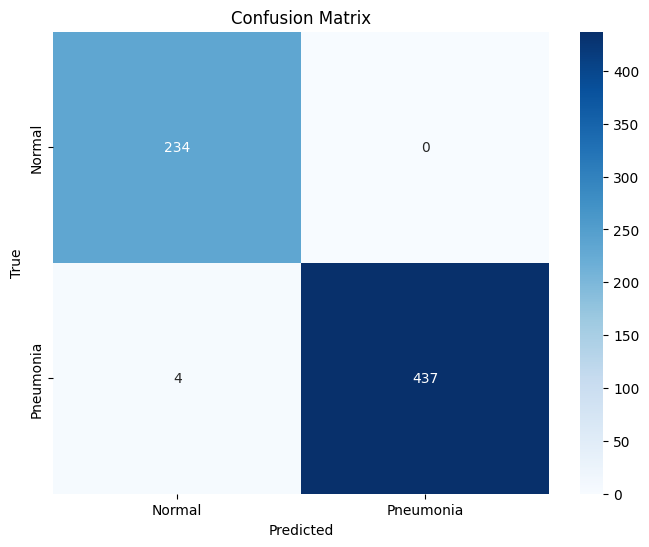

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Prediksi pada data test
y_pred = densenet169_model.predict(test_generator)
y_pred_classes = np.round(y_pred).astype(int)
y_true = test_generator.classes

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
# Ambil history dari pelatihan
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [12]:
# Set style untuk format IEEE
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'serif',
    'figure.dpi': 300,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})

C:\Users\Hazim\AppData\Local\Temp\ipykernel_25080\2963122678.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


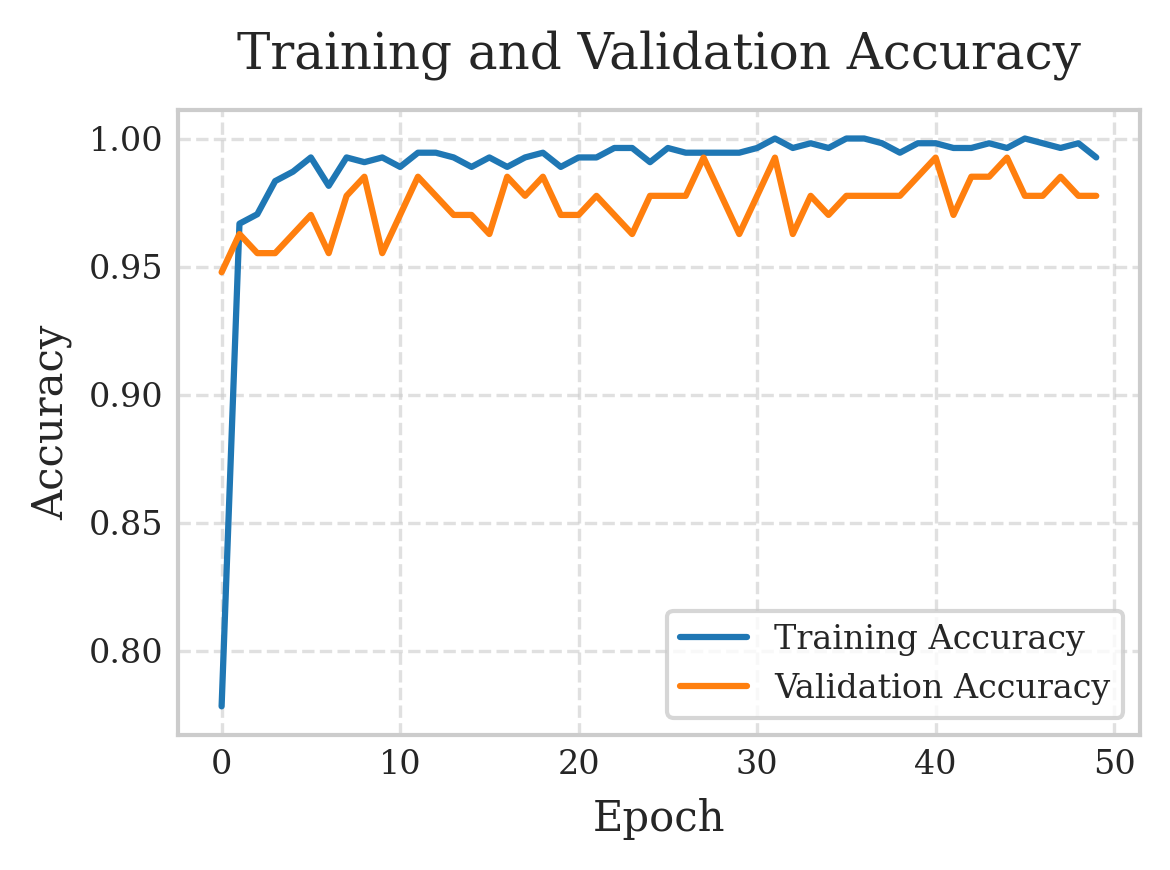

In [13]:
# Plot akurasi
plt.figure(figsize=(4, 3))
plt.plot(accuracy, label='Training Accuracy', linewidth=1.5)
plt.plot(val_accuracy, label='Validation Accuracy', linewidth=1.5)
plt.title('Training and Validation Accuracy', fontsize=12, pad=10)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.legend(loc='lower right', frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

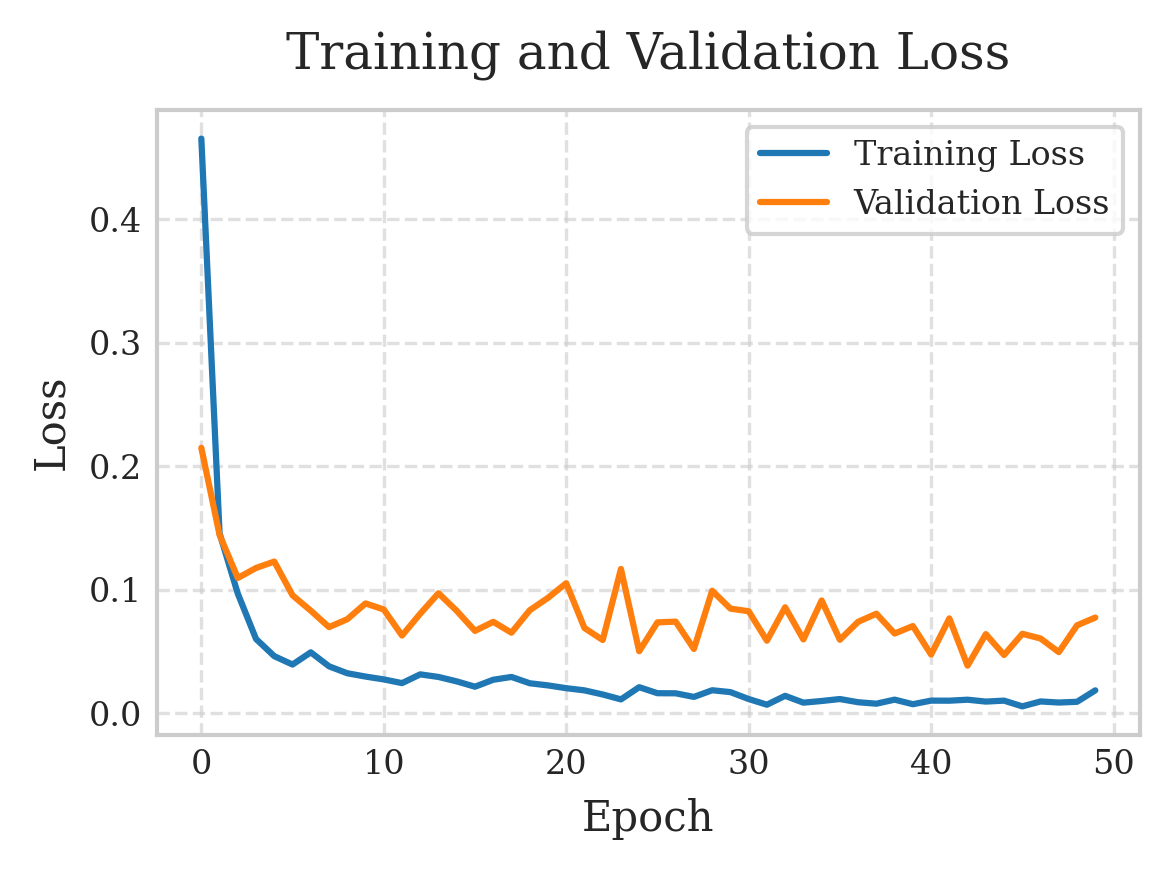

In [14]:
# Plot loss
plt.figure(figsize=(4, 3))
plt.plot(loss, label='Training Loss', linewidth=1.5)
plt.plot(val_loss, label='Validation Loss', linewidth=1.5)
plt.title('Training and Validation Loss', fontsize=12, pad=10)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(loc='upper right', frameon=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
def plot_images(images, true_labels, predicted_labels, class_names, correct=True):
    """
    Menampilkan gambar dengan label benar dan prediksi.

    Parameters:
        images (list): List gambar.
        true_labels (list): List label benar.
        predicted_labels (list): List label prediksi.
        class_names (list): Nama kelas (['Normal', 'Pneumonia']).
        correct (bool): Jika True, tampilkan prediksi yang benar. Jika False, tampilkan prediksi yang salah.
    """
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        
        # Konversi label ke integer
        true_label = int(true_labels[i])
        pred_label = int(predicted_labels[i][0])  # predicted_labels adalah array 2D
        
        plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}')
        plt.axis('off')
    plt.suptitle('Correct Predictions' if correct else 'Incorrect Predictions')
    plt.show()

In [ ]:
test_images, test_labels = next(test_generator)

# Prediksi kelas
predictions = densenet169_model.predict(test_images)
predicted_classes = np.round(predictions).astype(int)

# Mengambil true labels dari generator
y_true = test_generator.classes

# Mengambil beberapa contoh yang benar dan salah
correct_images = []
correct_true_labels = []
correct_pred_labels = []

incorrect_images = []
incorrect_true_labels = []
incorrect_pred_labels = []


correct_indices = []
incorrect_indices = []

# Loop melalui batch generator untuk mengambil gambar
for i in range(len(test_generator)):
    images, labels = test_generator[i]
    preds = densenet169_model.predict(images)
    preds_classes = np.round(preds).astype(int)


    correct_indices_batch = np.where(preds_classes.flatten() == labels)[0]
    incorrect_indices_batch = np.where(preds_classes.flatten() != labels)[0]


    correct_indices.extend(correct_indices_batch + i * test_generator.batch_size)
    incorrect_indices.extend(incorrect_indices_batch + i * test_generator.batch_size)


    for j in correct_indices_batch:
        correct_images.append(images[j])
        correct_true_labels.append(labels[j])
        correct_pred_labels.append(preds_classes[j])
    for j in incorrect_indices_batch:
        incorrect_images.append(images[j])
        incorrect_true_labels.append(labels[j])
        incorrect_pred_labels.append(preds_classes[j])


    if len(correct_images) >= 9 and len(incorrect_images) >= 9:
        break
# Ambil 9 sampel pertama
correct_images = correct_images[:9]
correct_true_labels = correct_true_labels[:9]
correct_pred_labels = correct_pred_labels[:9]

incorrect_images = incorrect_images[:9]
incorrect_true_labels = incorrect_true_labels[:9]
incorrect_pred_labels = incorrect_pred_labels[:9]

# Nama kelas
class_names = ['Normal', 'Pneumonia']

1/1 [==============================] - 2s 2s/step


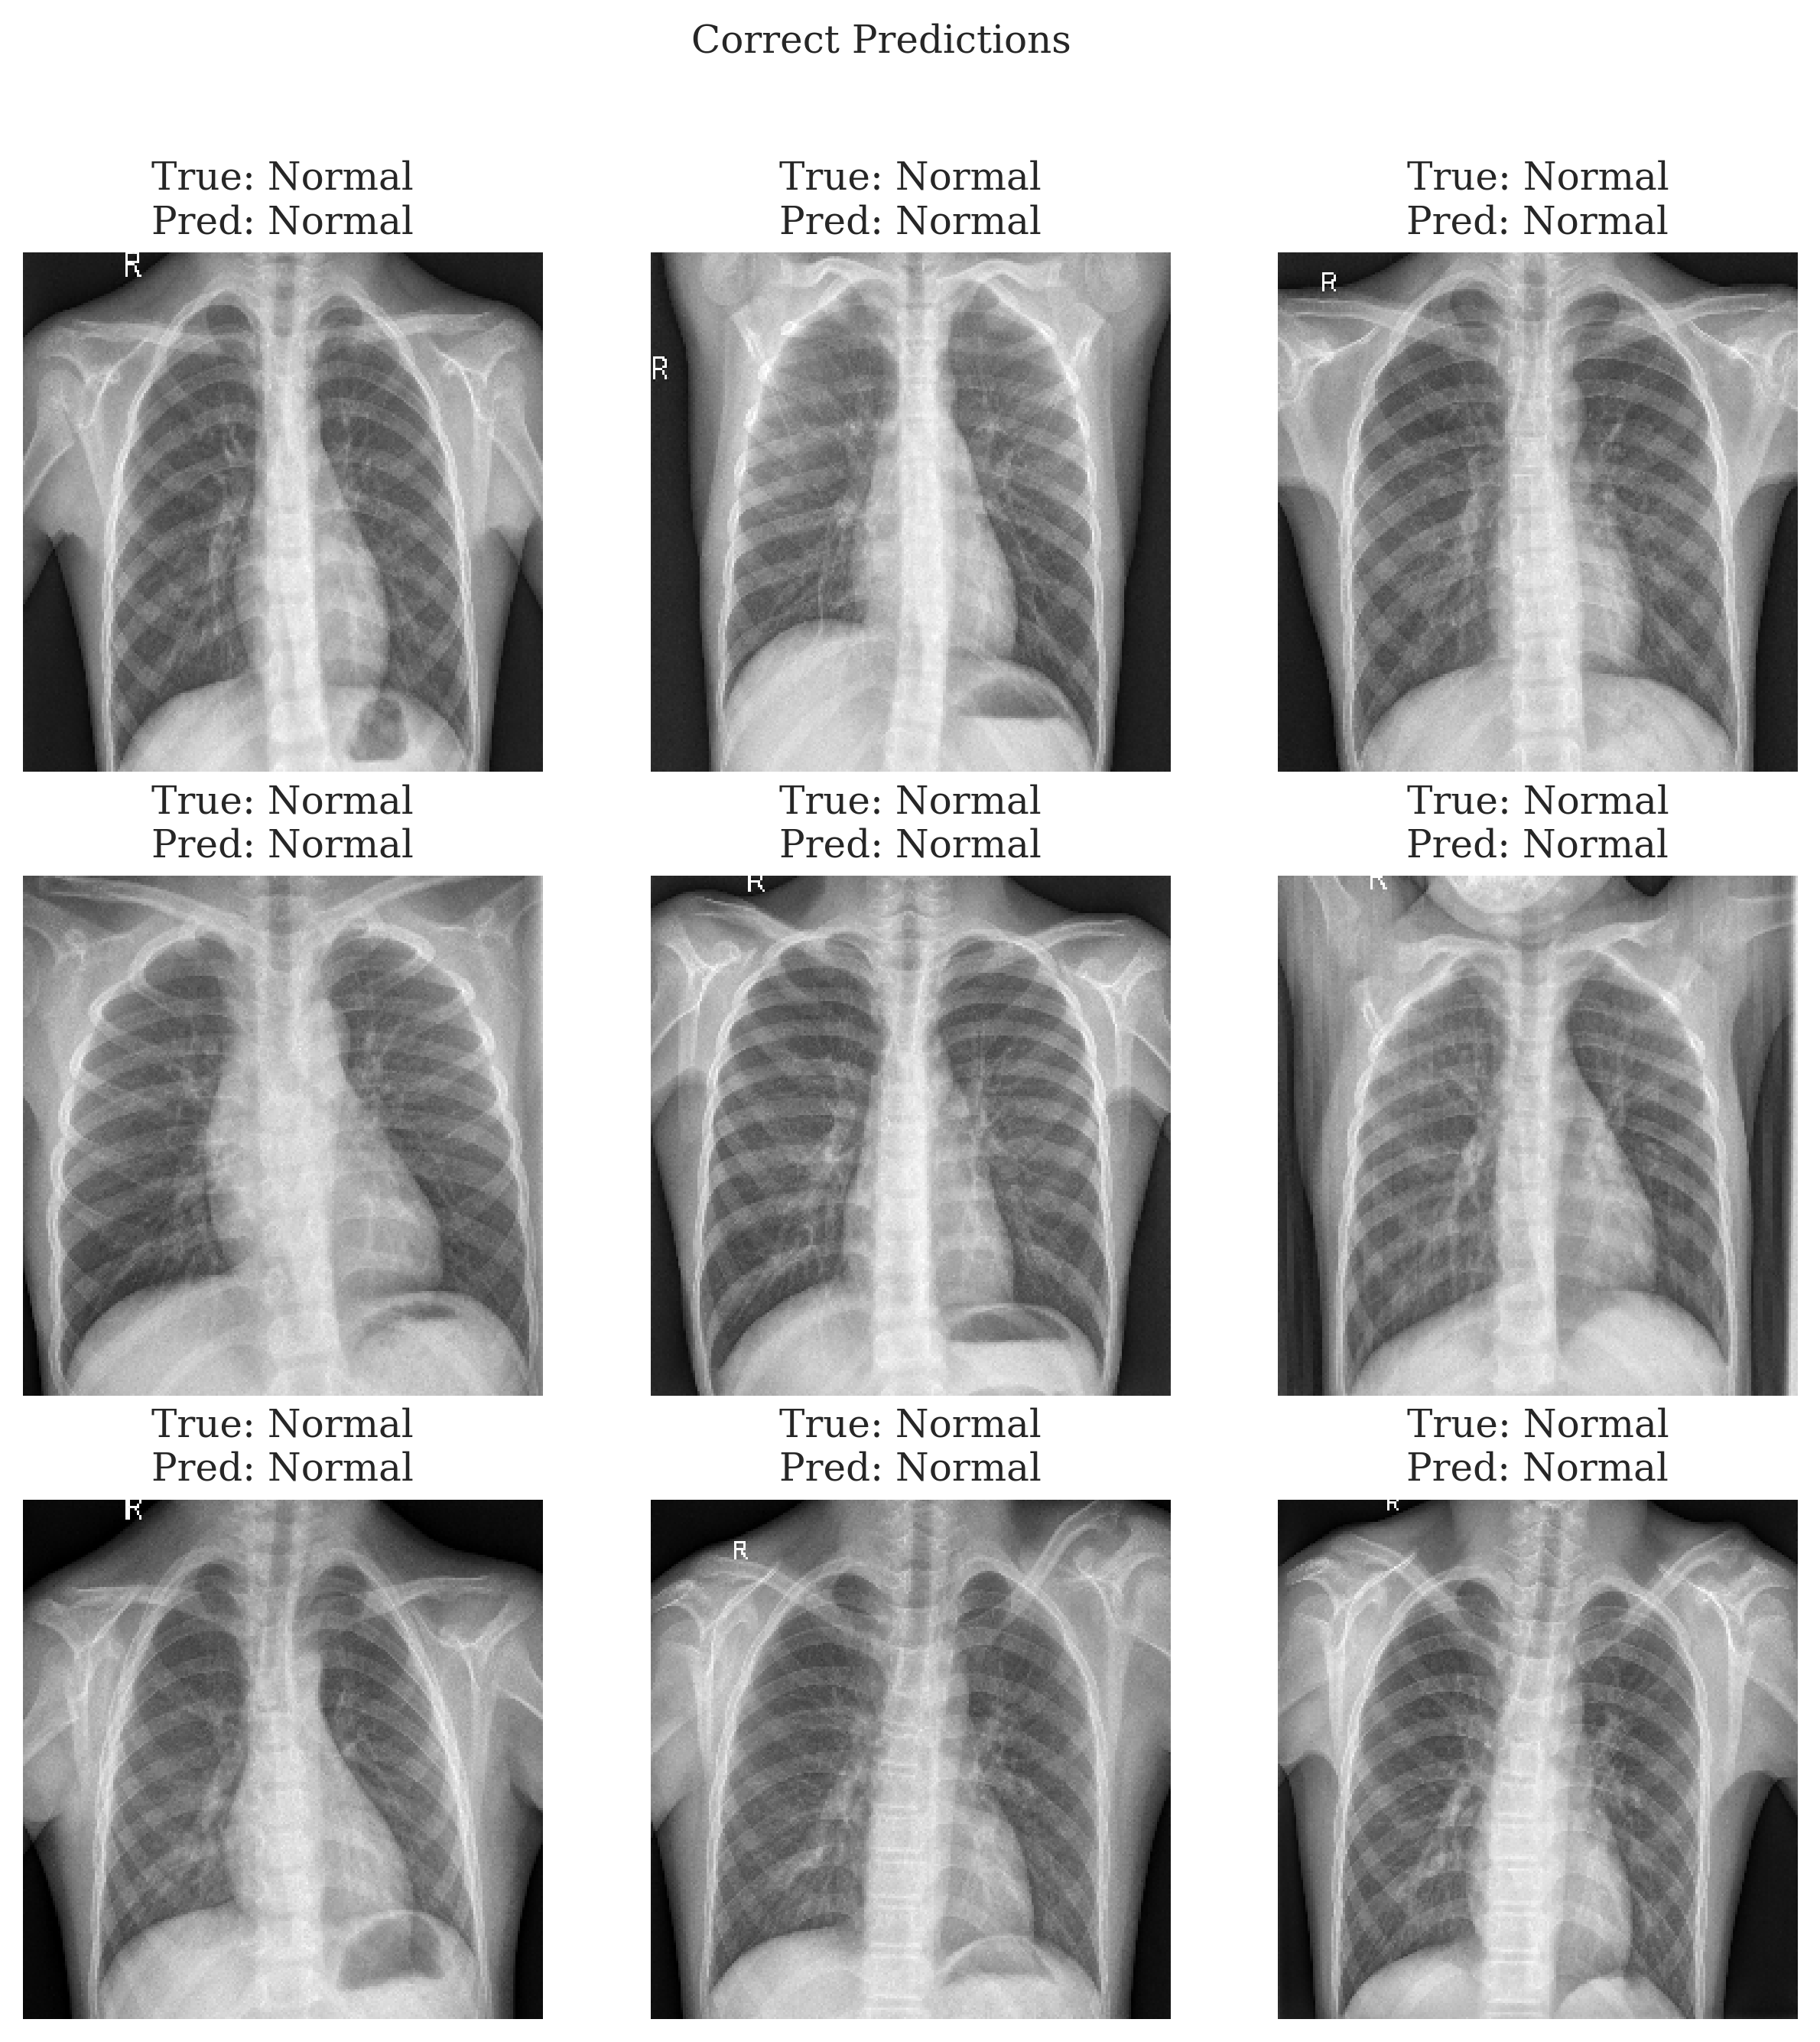

In [ ]:
# Tampilan prediksi yang benar
plot_images(correct_images, correct_true_labels, correct_pred_labels, class_names, correct=True)

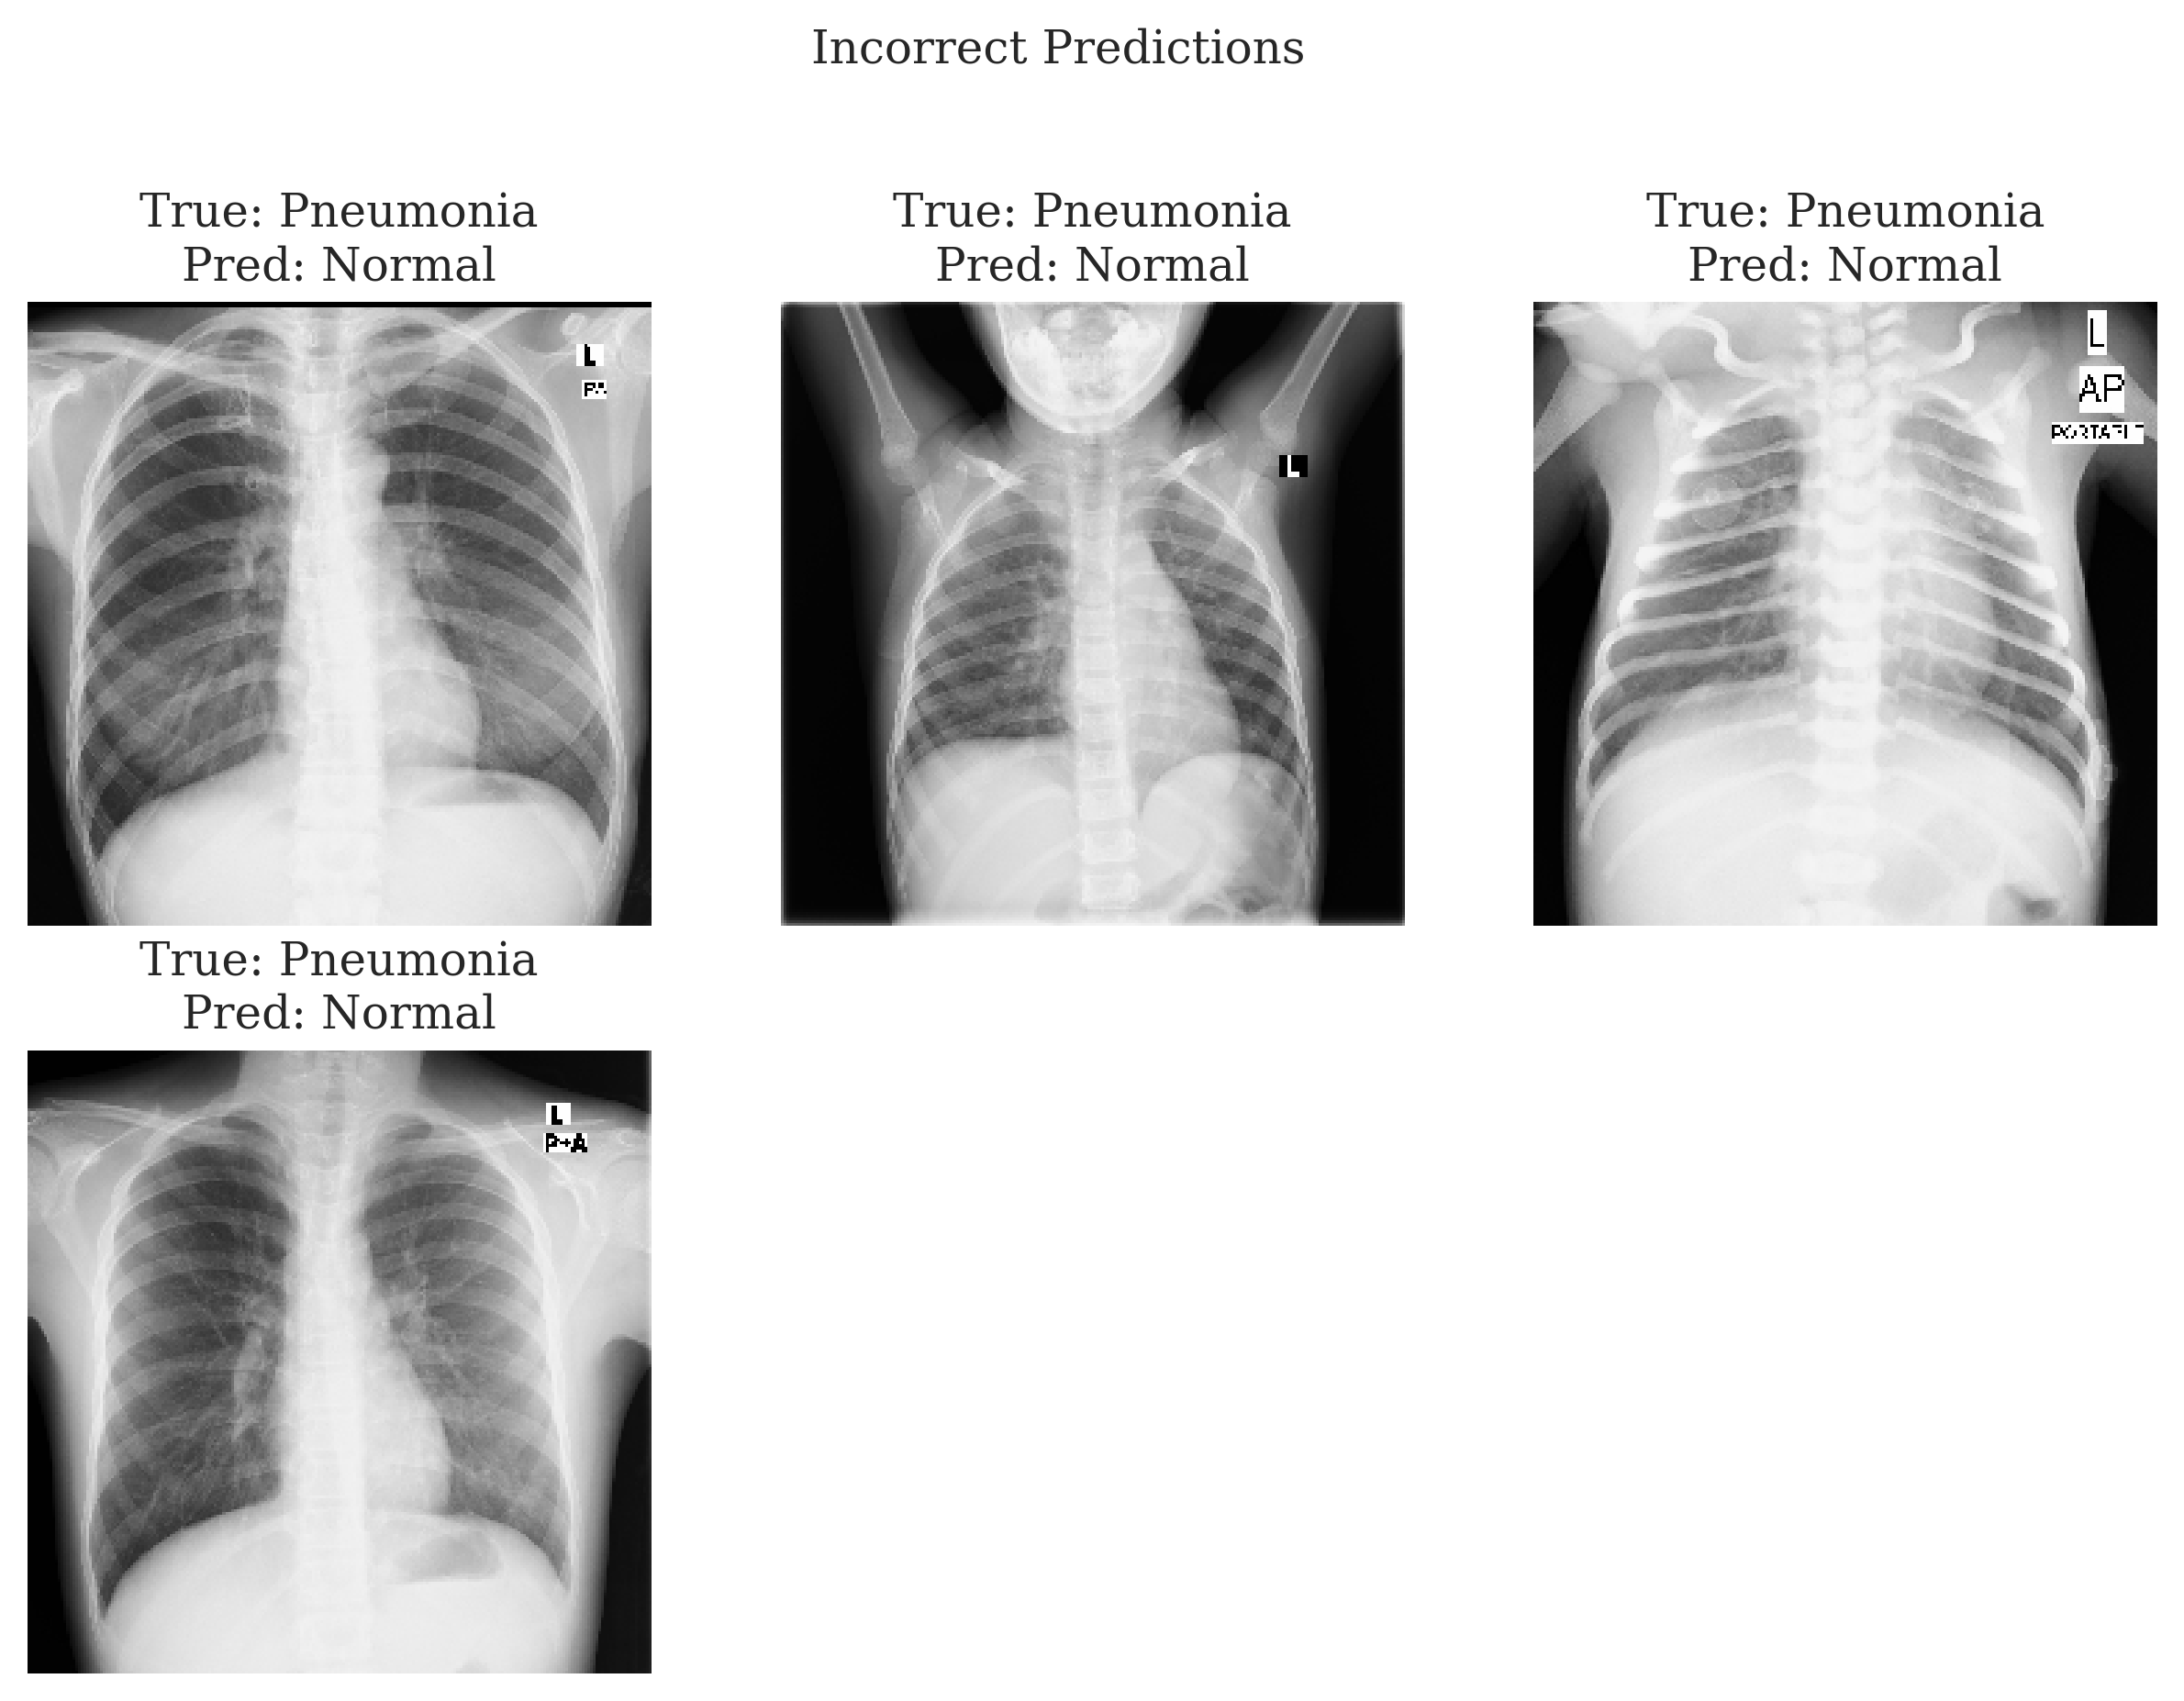

In [ ]:
# Tampilan prediksi yang salah
plot_images(incorrect_images, incorrect_true_labels, incorrect_pred_labels, class_names, correct=False)

In [19]:
# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Hitung jumlah prediksi yang salah
false_normal = cm[0, 1]  # True: Normal, Pred: Pneumonia
false_pneumonia = cm[1, 0]  # True: Pneumonia, Pred: Normal

# Total prediksi yang salah
total_false = false_normal + false_pneumonia

# Tampilkan hasil
print(f"Jumlah prediksi salah (True: Normal, Pred: Pneumonia): {false_normal}")
print(f"Jumlah prediksi salah (True: Pneumonia, Pred: Normal): {false_pneumonia}")
print(f"Total prediksi yang salah: {total_false}")

Jumlah prediksi salah (True: Normal, Pred: Pneumonia): 0
Jumlah prediksi salah (True: Pneumonia, Pred: Normal): 4
Total prediksi yang salah: 4


In [20]:
# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Hitung jumlah prediksi yang benar
true_normal = cm[0, 0]  # True: Normal, Pred: Normal
true_pneumonia = cm[1, 1]  # True: Pneumonia, Pred: Pneumonia

# Total prediksi yang benar
total_true = true_normal + true_pneumonia

# Tampilkan hasil
print(f"Jumlah prediksi benar (True: Normal, Pred: Normal): {true_normal}")
print(f"Jumlah prediksi benar (True: Pneumonia, Pred: Pneumonia): {true_pneumonia}")
print(f"Total prediksi yang benar: {total_true}")

Jumlah prediksi benar (True: Normal, Pred: Normal): 234
Jumlah prediksi benar (True: Pneumonia, Pred: Pneumonia): 437
Total prediksi yang benar: 671
